In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import os
from datetime import datetime
from dateutil import relativedelta
from tqdm import tqdm
from pathlib import Path
import json
from multiprocessing import Pool

from datetime import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from utils import *
from local_testing import *

In [17]:
def get_err(linea, date, FC='AA', PQ=False, output='DATA', metric='ABS_ERROR', aggr='ROT', REL_ERROR=False):
    
    """
    metric=['ABS_ERROR', 'ERROR']
    output=['DATA', 'PLOT']
    aggr=['ROT', 'CLASS']
    
    """

    fc_cv = get_fc_sem(linea, date, FC)

    dda = get_dda_sem(linea, date)

    df = get_fc(linea, partner='BP')
    df = df[df.date==date]
    fc_bp = trans_fc_sem(df, 'BP')

    masterdata = get_masterdata(linea, date)
    masterdata.drop_duplicates(subset='REF_CODE', keep='first', inplace=True)
    masterdata.set_index('REF_CODE', inplace=True)

    data = fc_cv.merge(dda, left_index=True, right_index=True, how='left')
    data = data.merge(fc_bp, left_index=True, right_index=True, how='left')
    data = data.merge(masterdata, left_index=True, right_index=True, how='left')
    print('PNs :', data.shape[0])

    if not PQ:
        if metric=='ABS_ERROR':
            data['ERRABS_' + FC] = abs(data[FC] - data['DA']) 
            data['ERRABS_BP'] = abs(data['BP'] - data['DA']) 
        if metric=='ERROR':
            data['ERRABS_' + FC] = data[FC] - data['DA'] 
            data['ERRABS_BP'] = data['BP'] - data['DA'] 

    if PQ:
        if metric=='ABS_ERROR':
            data['ERRABS_' + FC] = abs(data[FC] - data['DA']) * data['RC_AVG_PRICE']
            data['ERRABS_BP'] = abs(data['BP'] - data['DA']) * data['RC_AVG_PRICE']
        if metric=='ERROR':
            data['ERRABS_' + FC] = (data[FC] - data['DA']) * data['RC_AVG_PRICE']
            data['ERRABS_BP'] = (data['BP'] - data['DA']) * data['RC_AVG_PRICE']
            
    if output=='PLOT':
        if aggr=='ROT':
            data_group = 'RC_ROTACION'
        if aggr=='CLASS':
            data_group = 'RC_CLASS_SUPPLY'           
        
        if REL_ERROR:
            df = data.groupby(data_group).sum()
            if PQ:
                df['DA'] = df['DA'] * df['RC_AVG_PRICE']
                df['ERRABS_'+ FC] = df['ERRABS_'+ FC] / df['DA']
                df['ERRABS_BP'] = df['ERRABS_BP'] / df['DA']
            if not PQ:
                df['ERRABS_'+ FC] = df['ERRABS_'+ FC] / df['DA']
                df['ERRABS_BP'] = df['ERRABS_BP'] / df['DA']

        if not REL_ERROR:
            df = data.groupby(data_group).sum()

        if aggr=='ROT':
            df = df.reindex(['FM', 'MM', 'SM', 'NM'])
        if aggr=='CLASS':
            df = df.reindex(['COMPONENTE', 'CONSUMO', 'OTROS'])        

        rot=df.index
        fig = go.Figure(data=[
            go.Bar(name='AA', x=rot, y=df['ERRABS_'+ FC], text=df['ERRABS_'+ FC], textposition='auto'),
            go.Bar(name='BP', x=rot, y=df['ERRABS_BP'], text=df['ERRABS_BP'], textposition='auto'),
        ])
        fig.update_layout(barmode='group')
        
        if metric=='ABS_ERROR':
            title_error = 'Error Absoluto'
        if metric=='ERROR':
            title_error = 'Error'
       
        if PQ:
            fig.update_layout(
                title= title_error + ' en relación a la Demanda real: Monto Capital $USD (P*Q) (' + linea +', 6 meses a continuación del mes ' + date + ')',
                yaxis_title="$USD")
        if not PQ:
            fig.update_layout(
                title= title_error + " en relación a la Demanda real: Cantidad de Materiales (" + linea +', 6 meses a continuación del mes ' + date + ')',
                yaxis_title="Unidades")
        fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
        fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
        fig.show() 

    if output=='DATA':
        return data


In [30]:
def get_fc_aa(linea):
        
    if linea=="SSC": 
        client = bigquery.Client()
        query = """
            SELECT * FROM `bc-ed-advaa-dev-nc0h.supply_forecast.ssc_fc_aa`
        """

        query_job = client.query(query)
        df = query_job.to_dataframe()
        df.rename({'forecast_date': 'date'}, axis=1, inplace=True)
        
        
    if linea=="BRA":
        client = bigquery.Client()

        query = """
            SELECT * FROM `bc-ed-advaa-dev-nc0h.supply_forecast.bra_fc_aa`
        """

        query_job = client.query(query)
        df = query_job.to_dataframe()
               
    if linea=="MRO":
        query = """
            SELECT * FROM `bc-ed-advaa-dev-nc0h.supply_forecast.mro_fc_aa`
        """

        client = bigquery.Client()
        query_job = client.query(query)

        df = query_job.to_dataframe()
        df.rename(columns={"REFERENCE_CODE": "REF_CODE"}, inplace = True)
        
    
    return df


In [19]:
def get_plot_tipos(linea, date, FC, PN1=False):

    data = get_err(linea, date, FC, PQ=False, output='DATA', metric='ERROR')

    data['ERROR_AA'] = data['ERRABS_' + FC]
    data['ERROR_BP'] = data['ERRABS_BP']    
    data.dropna(subset=['RC_AVG_PRICE'], inplace=True)

    pos_pos = data[np.logical_and(data['ERROR_AA']>=0, data['ERROR_BP']>=0)]
    pos_pos['TIPO'] = '++'

    neg_neg = data[np.logical_and(data['ERROR_AA']<0, data['ERROR_BP']<0)]
    neg_neg['TIPO'] = '--'

    pos_neg = data[np.logical_and(data['ERROR_AA']>=0, data['ERROR_BP']<0)]
    pos_neg['TIPO'] = '+-'

    neg_pos = data[np.logical_and(data['ERROR_AA']<0, data['ERROR_BP']>=0)]
    neg_pos['TIPO'] = '-+'

    df = pos_pos.append(neg_neg).append(pos_neg).append(neg_pos)

    PNs = dict()
    PNs['++'] = pos_pos.shape[0]
    PNs['--'] = neg_neg.shape[0]
    PNs['+-'] = pos_neg.shape[0]
    PNs['-+'] = neg_pos.shape[0]
    
    df['ERRORABS_AA'] = np.abs(df['ERROR_AA'])
    df['ERRORABS_BP'] = np.abs(df['ERROR_BP']) 
    
    df['ERRORABS_PQ_AA'] = df['ERRORABS_AA'] * df['RC_AVG_PRICE'] 
    df['ERRORABS_PQ_BP'] = df['ERRORABS_BP'] * df['RC_AVG_PRICE'] 

    df_plot = df.groupby('TIPO').sum()[['ERRORABS_AA', 'ERRORABS_BP', 'ERRORABS_PQ_AA', 'ERRORABS_PQ_BP']]
    print(PNs)
    
    if PN1:
        df_plot = df_plot.merge(df, left_index=True, right_index=True) / df_plot['TIPOS_N']

    # ERRORABS
    fig = go.Figure(data=[
        go.Bar(name='AA', x=df_plot.index, y=df_plot.ERRORABS_PQ_AA, text=df_plot.ERRORABS_PQ_AA, textposition='auto'),
        go.Bar(name='BP', x=df_plot.index, y=df_plot.ERRORABS_PQ_BP, text=df_plot.ERRORABS_PQ_BP, textposition='auto'),
    ])
    fig.update_layout(barmode='group')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.update_layout(
        title= 'Error Absoluto en relación a la demanda real: Monto Capital $USD (P*Q) (' + linea +', 6 meses a continuación del mes ' + date + ')',
        yaxis_title="$USD")
    fig.show()
    

# BRA

PNs : 13719
{'++': 1236, '--': 1872, '+-': 671, '-+': 204}


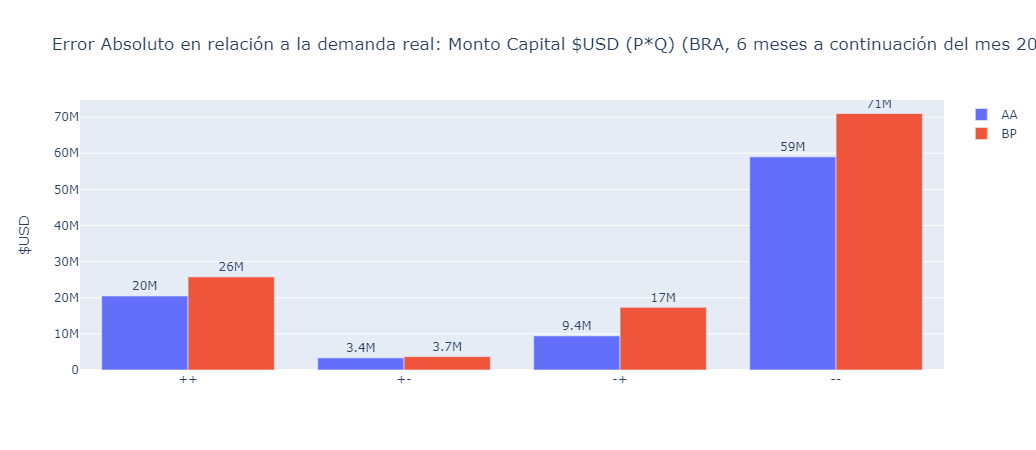

PNs : 13719


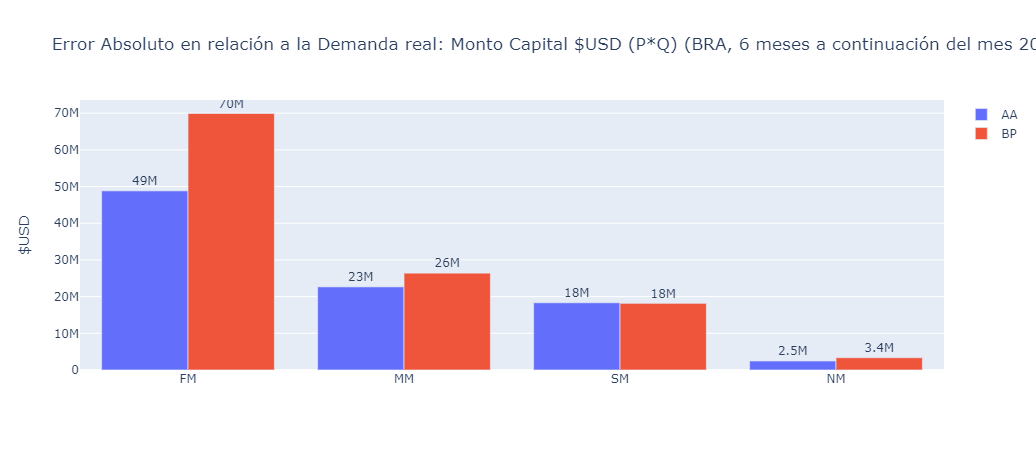

PNs : 13719


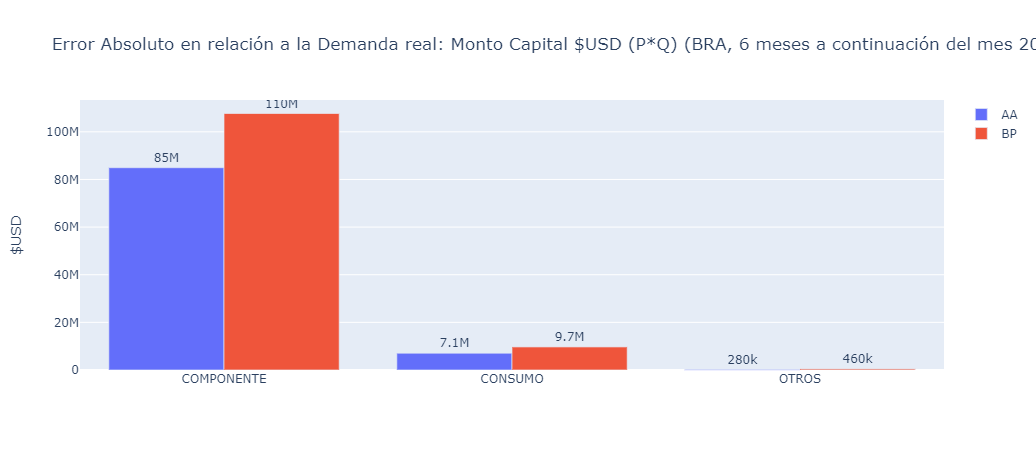

In [22]:
FC='WINSOR_80'
linea = 'BRA'
date = '2019-06-01'

get_plot_tipos(linea, date, FC)
get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='ROT')
get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='CLASS')

# MRO

PNs : 8440
{'++': 3094, '--': 3246, '+-': 571, '-+': 1277}


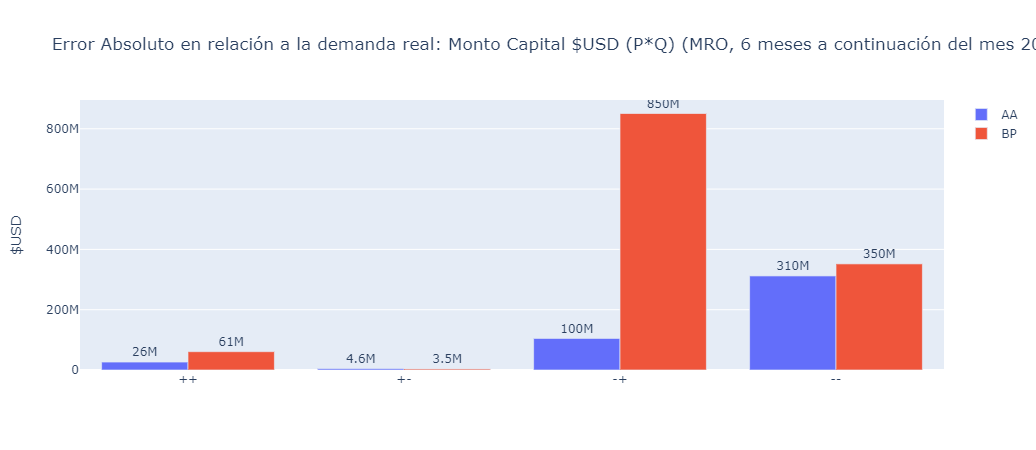

PNs : 8440


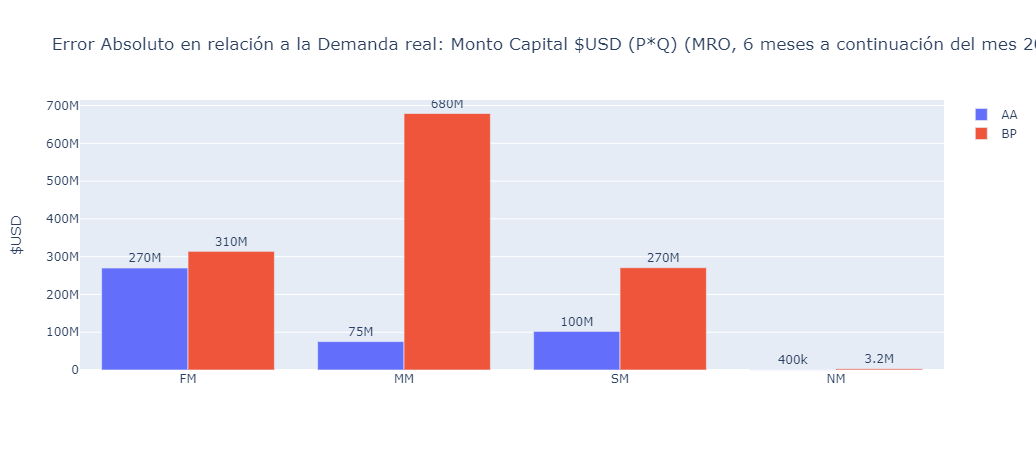

In [23]:
FC='CV_1'
linea = 'MRO'
date = '2019-01-01'

get_plot_tipos(linea, date, FC)
get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='ROT')
# get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='CLASS')

# SSC

PNs : 23310
{'++': 12835, '--': 7363, '+-': 1605, '-+': 1499}


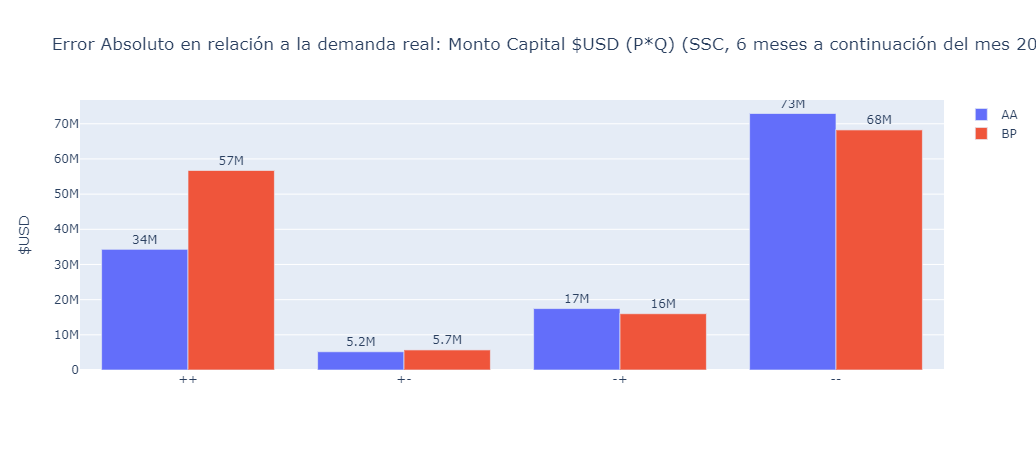

PNs : 23310


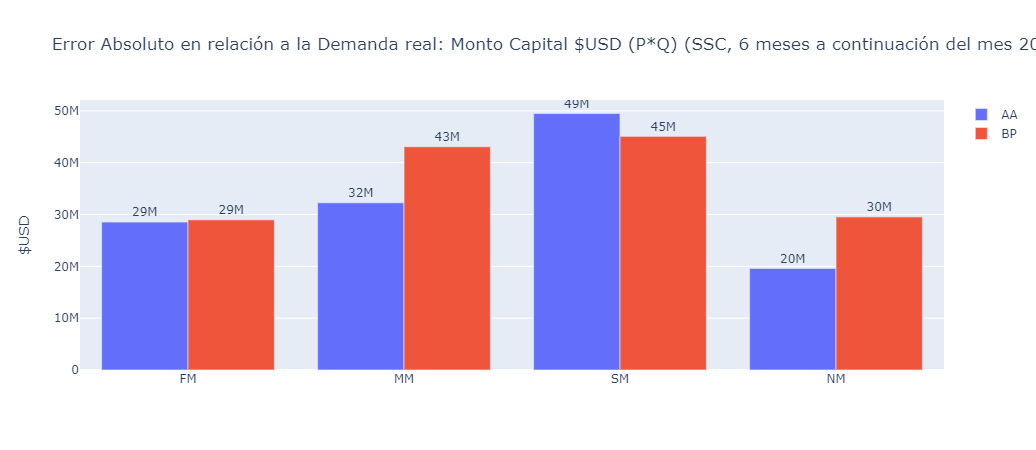

PNs : 23310


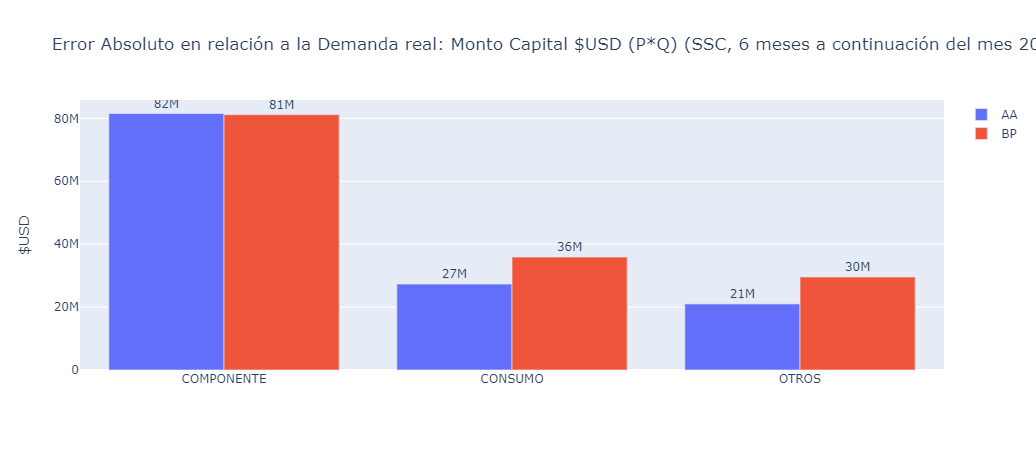

In [28]:
FC='CV_with_outliers'
linea = 'SSC'
date = '2019-01-01'

get_plot_tipos(linea, date, FC)
get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='ROT')
get_err(linea, date, FC, PQ=True, output='PLOT', metric='ABS_ERROR', aggr='CLASS')

# Plot: Price vs. Demand

In [302]:
linea = 'SSC'
date = '2019-01-01'

In [321]:
dda = get_dda_sem(linea, date, months=18)

In [322]:
masterdata = get_masterdata(linea, date)
masterdata.drop_duplicates(subset='REF_CODE', keep='first', inplace=True)
masterdata.set_index('REF_CODE', inplace=True)
df = dda.merge(masterdata, left_index=True, right_index=True, how='left')

In [323]:
df['log_DA'] = np.log(df['DA'])
df['log_P'] = np.log(df['RC_AVG_PRICE'])

df = df[df.log_P>0]
df = df[df.log_DA>0]

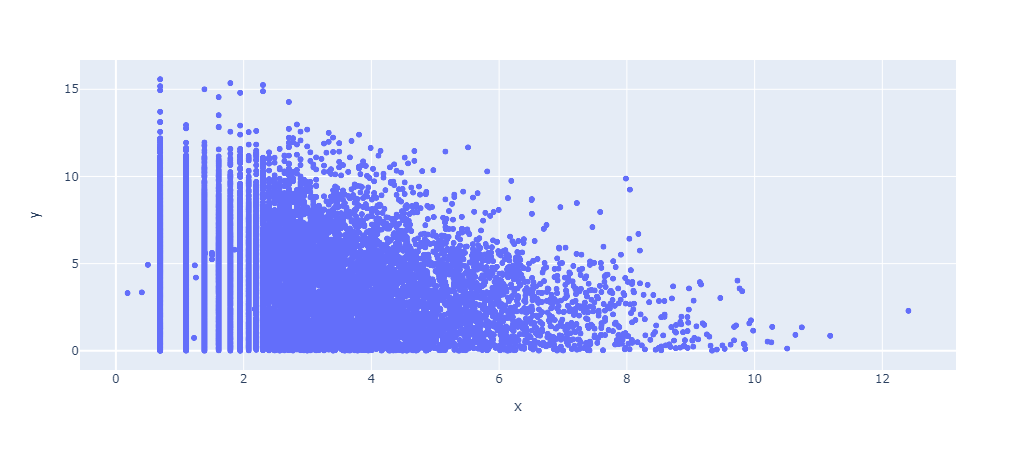

In [324]:
fig = px.scatter(x=df.log_DA, y=df.log_P)
fig.show()

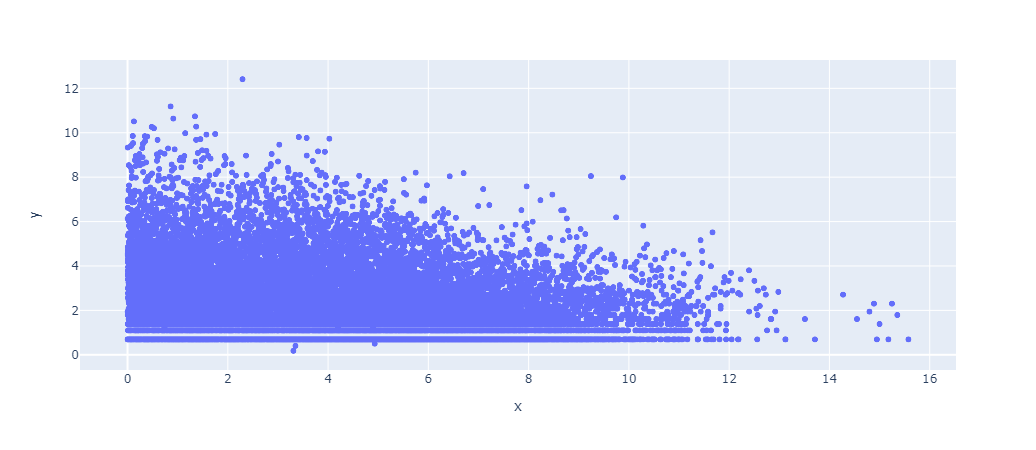

In [325]:
fig = px.scatter(x=df.log_P, y=df.log_DA)
fig.show()

In [326]:
from statsmodels.formula.api import ols
model = ols("log_DA ~ C(RC_ROTACION) + C(RC_CLASS_SUPPLY) + log_P", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_DA   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     1722.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        05:25:47   Log-Likelihood:                -27003.
No. Observations:               16633   AIC:                         5.402e+04
Df Residuals:                   16624   BIC:                         5.409e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.1720      0.056    110.945      0.000       6.063       6.281
C(RC_ROTACION)[T.MM]                  -1.5992      0.044    -36.581      0.000      -1.685      -1.513
C(RC_ROTACION)[T.NM]                  -3.5710      0.038    -94.376      0.000      -3.645      -3.497
C(RC_ROTACION)[T.SM]                  -2.9871      0.037    -80.271      0.000      -3.060      -2.914
C(RC_CLASS_SUPPLY)[T.CONSUMO]         -0.1940      0.039     -4.988      0.000      -0.270      -0.118
C(RC_CLASS_SUPPLY)[T.MAIN ROTABLE]     0.7734      0.258      2.996      0.003       0.267       1.280
C(RC_CLASS_SUPPLY)[T.OTROS]            1.0495      0.300      3.501      0.000       0.462       1.637
C(RC_CLASS_SUPPLY)[T.TOOL]            -0.4313      0.107     -4.018      0.000      -0.642      -0.221
log_P                                 -0.1588      0.004    -38.281      0.000      -0.167      -0.151
==============================================================================
Omnibus:                     2784.617   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5739.173
Skew:                           1.006   Prob(JB):                         0.00
Kurtosis:                       5.057   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [361]:
data = df.groupby('RC_ROTACION').median()
data = data.reindex(['FM', 'MM', 'SM', 'NM'])
data.reset_index(inplace=True)
data

RC_ROTACION     DA  RC_PRECIO  PN_PRECIO  RC_AVG_PRICE    log_DA     log_P  \
0          FM  186.0   28.77000   24.53000      28.46923  5.225747  3.348824   
1          MM   37.5   55.54500   49.81604      56.45032  3.624252  4.033360   
2          SM    9.0   66.56826   60.94500      65.83727  2.197225  4.187186   
3          NM    4.0   79.44638   76.13000      78.43078  1.386294  4.362216   

           PQ  
0  7469.68352  
1  2443.84062  
2   660.93355  
3   414.04022

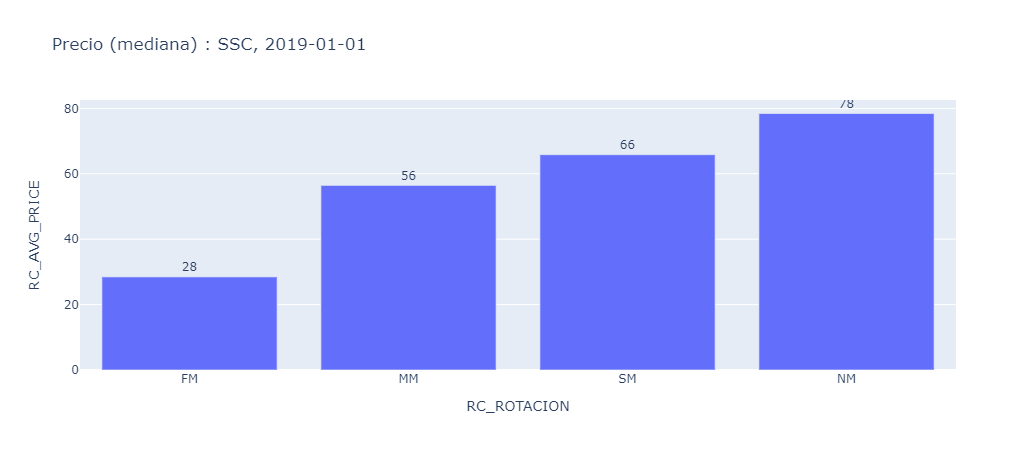

In [362]:
fig = px.bar(data, x='RC_ROTACION', y='RC_AVG_PRICE', title="Precio (mediana) : " + linea + ', ' + date)
fig.update_traces(text=data.RC_AVG_PRICE, texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [363]:
data = df.groupby('RC_ROTACION').sum()
data = data.reindex(['FM', 'MM', 'SM', 'NM'])
data.reset_index(inplace=True)
data

RC_ROTACION          DA     RC_PRECIO     PN_PRECIO  RC_AVG_PRICE  \
0          FM  1532080.22  3.770284e+06  3.821217e+06  2.231974e+06   
1          MM   260021.94  1.986769e+07  1.949685e+07  1.656536e+07   
2          SM   430677.90  3.502835e+07  3.471355e+07  2.867380e+07   
3          NM   143697.99  2.894773e+07  2.854644e+07  2.657983e+07   

         log_DA         log_P            PQ  
0   7017.873067   4679.802186  3.065131e+08  
1   7601.851349   8479.901986  2.562687e+08  
2  16784.453456  30513.077663  2.149454e+08  
3  10542.059036  26865.079819  1.328283e+08

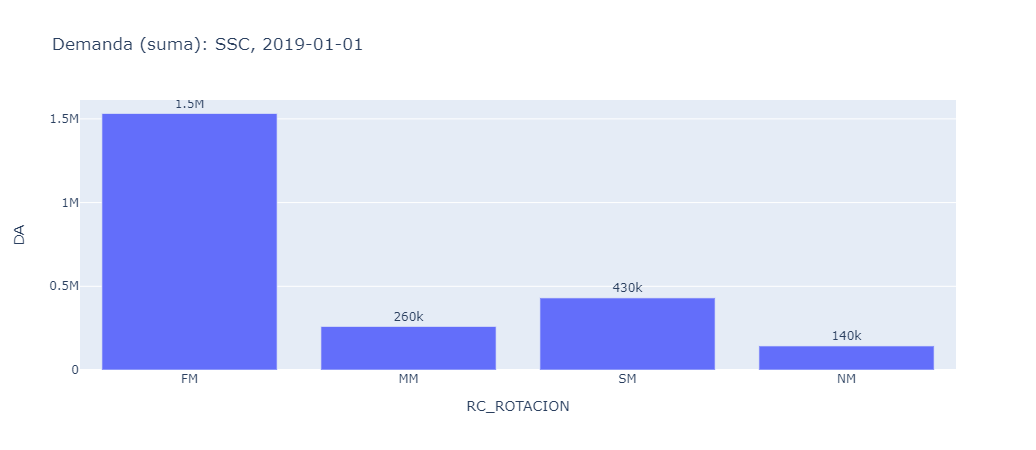

In [364]:
fig = px.bar(data, x='RC_ROTACION', y='DA', title="Demanda (suma): " + linea + ', ' + date)
fig.update_traces(text=data.DA, texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [367]:
df['PQ'] = df['DA'] * df['RC_AVG_PRICE']

In [368]:
data = df.groupby('RC_ROTACION').sum()
data = data.reindex(['FM', 'MM', 'SM', 'NM'])
data.reset_index(inplace=True)
data

RC_ROTACION          DA     RC_PRECIO     PN_PRECIO  RC_AVG_PRICE  \
0          FM  1532080.22  3.770284e+06  3.821217e+06  2.231974e+06   
1          MM   260021.94  1.986769e+07  1.949685e+07  1.656536e+07   
2          SM   430677.90  3.502835e+07  3.471355e+07  2.867380e+07   
3          NM   143697.99  2.894773e+07  2.854644e+07  2.657983e+07   

         log_DA         log_P            PQ  
0   7017.873067   4679.802186  3.065131e+08  
1   7601.851349   8479.901986  2.562687e+08  
2  16784.453456  30513.077663  2.149454e+08  
3  10542.059036  26865.079819  1.328283e+08

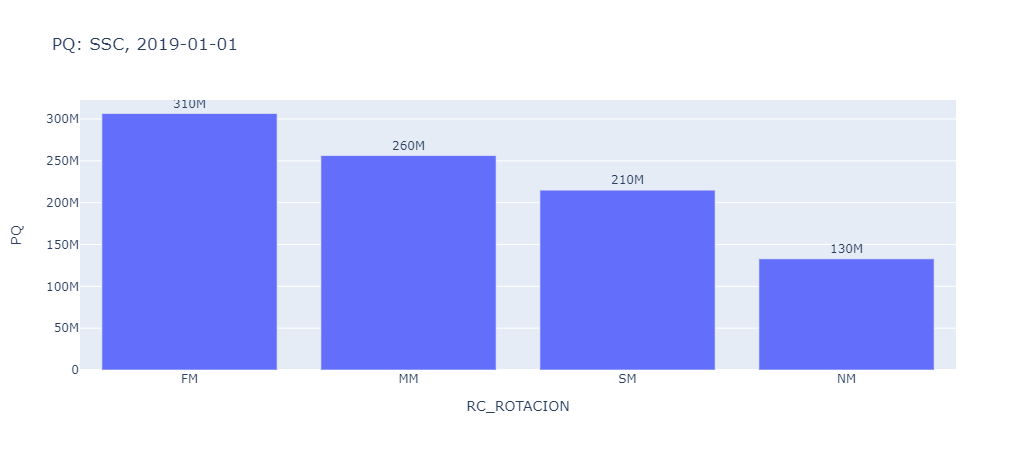

In [369]:
fig = px.bar(data, x='RC_ROTACION', y='PQ', title="PQ: " + linea + ', ' + date)
fig.update_traces(text=data.PQ, texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# KPI

In [438]:
linea = 'MRO'
date = '2019-01-01'

PNs : 8440


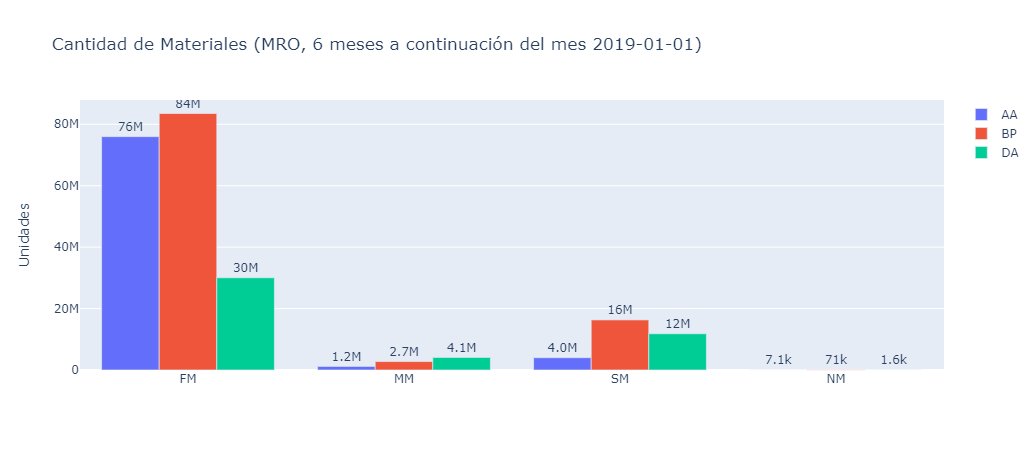

In [439]:
get_cantidad(linea, date, FC='CV_1', PQ=False, output='PLOT', aggr='ROT')

PNs : 8440


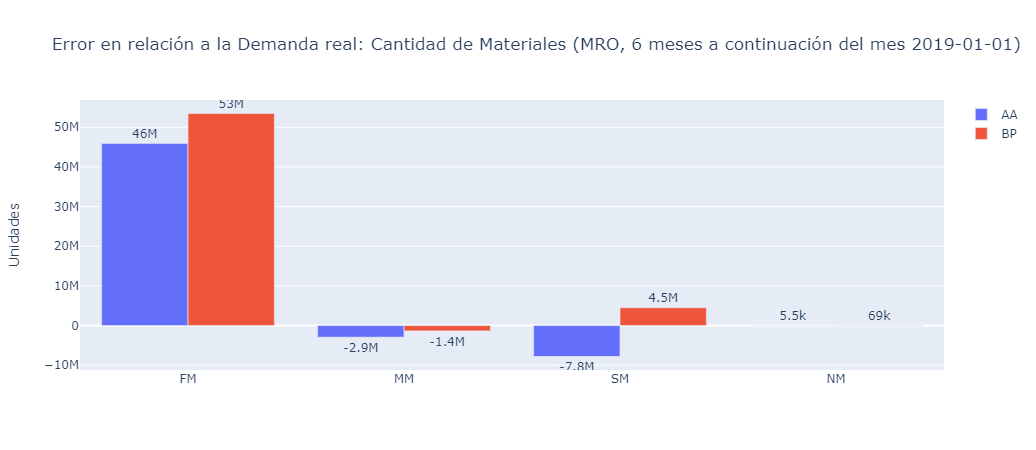

In [440]:
get_err(linea, date, FC='CV_1', PQ=False, output='PLOT', metric='ERROR', aggr='ROT') 

PNs : 8440


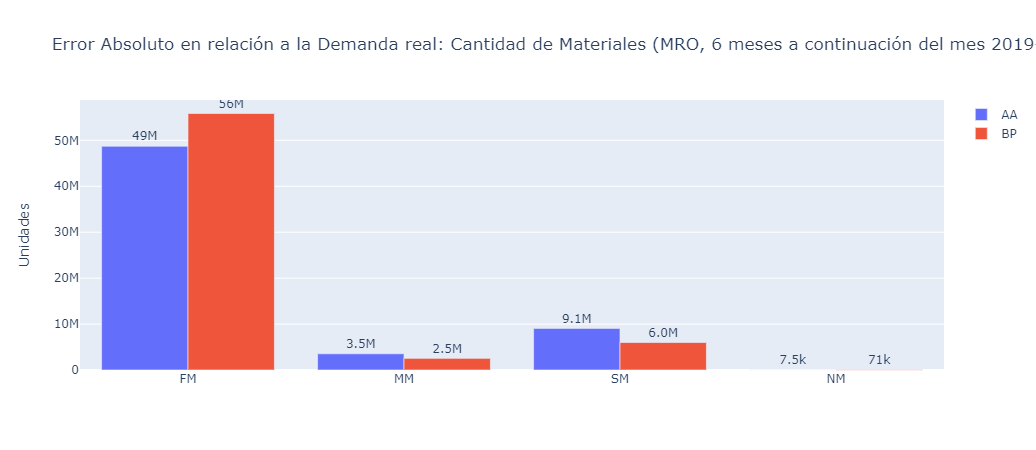

In [441]:
get_err(linea, date, FC='CV_1', PQ=False, output='PLOT', metric='ABS_ERROR', aggr='ROT')

PNs : 8440


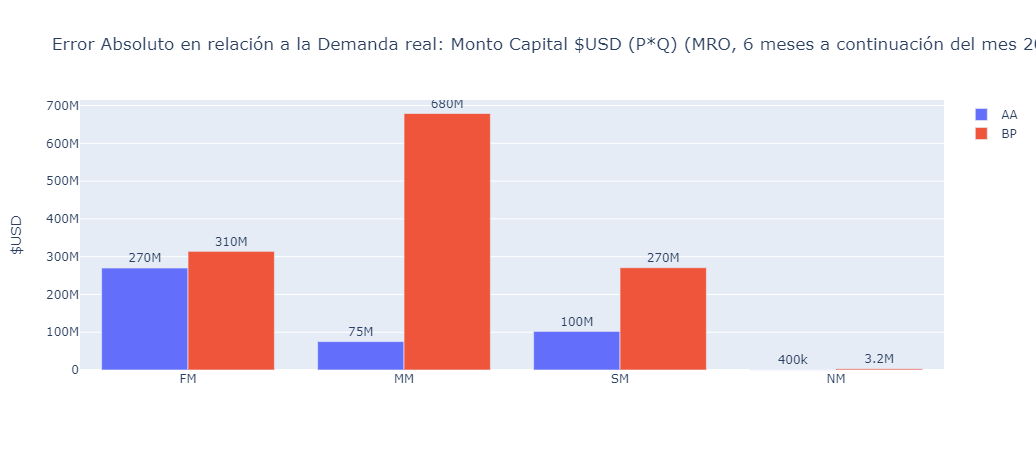

In [443]:
get_err(linea, date, FC='CV_1', PQ=True, output='PLOT', metric='ABS_ERROR', aggr='ROT')